<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/cnn/beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎨 AIは「計算」する：CNNによる画像分類と学習の可視化

こんにちは。このノートブックでは、AI（人工知能）がどのようにして画像を見分ける（**クラス分類**）ようになるのかを、一緒に体験していきます。

## 🤖 1. AIは「思考」ではなく「計算」をしている

AIというと、まるで人間のように「考えて」いるように思えますが、現在のAI（特にディープラーニング）の正体は、膨大な**「計算」**です。

* **入力：** 画像（たくさんのピクセルの集まり＝数値）
* **処理：** モデル（計算のルールを詰め込んだもの）が、入力された数値を次々と計算
* **出力：** 計算結果（例：「この画像が『ネコ』である確率は80%」といった数値）

AIの「学習」とは、この**計算ルール（モデルの中身）を、目的に合わせて少しずつ調整していく作業**のことです。

## 📁 2. データの準備と歴史：「特徴」をどう見つけるか

画像を分類するためには、画像の中の「特徴」を見つける必要があります。

### 📜 AIの歴史：特徴抽出の自動化

* **昔（～2010年頃）：**
    人間が「特徴とは何か」を必死に考えていました。「ネコの特徴は、三角の耳と丸い目だ」といったルール（**特徴量**）を人間が手動で設計し、AI（当時はサポートベクターマシンなどが主流）に教えていました。
* **今（ディープラーニングの時代）：**
    人間が特徴を設計するのではなく、AI自身がデータ（大量の画像）から「分類に役立つ特徴」を自動で見つけ出すようになりました。その代表的な手法が **CNN（畳み込みニューラルネットワーク）** です。

### 📚 教師あり学習：お手本（教師）データで学ぶ

今回は「**教師あり学習**」という方法を使います。これは、AIに「問題（画像）」と「正解（ラベル）」のペアをたくさん見せて学習させる方法です。

データは以下の3種類に分けて使います。
1.  **教師データ (Training data):**
    学習に使うメインのデータ。AIはこれを見て計算ルールを調整します。
2.  **検証データ (Validation data):**
    学習の途中で「今の実力」を試すためのデータ。学習の「やりすぎ」（過学習）を防ぐために使います。
3.  **テストデータ (Test data):**
    学習には一切使わない、最後の実力テスト用のデータ。これでAIの最終的な性能を評価します。

ここでは「CIFAR-10」という、10種類の画像（飛行機、車、鳥、猫など）を集めたデータセットを使います。

## 🛠️ 3. 準備：ライブラリと関数の読み込み

（このセルは、Pythonやプログラミングに詳しくない方は、中身を見ずに実行だけしてください。「準備のおまじない」のようなものです）

ここでは、AIの計算（PyTorch）、データの可視化（Matplotlib, t-SNE）、Colabのフォーム機能など、必要な道具（ライブラリ）を読み込んでいます。

**t-SNEとは？**
「畳み込み」などで取り出された「特徴（たくさんの数値）」は、そのままでは多すぎて人間には理解できません。t-SNEは、そうした高次元のデータを、お互いの「近さ」を保ったまま、2次元のグラフ（散布図）にぎゅっと圧縮してくれる技術です。

使用するデバイス: cuda:0
全学習データ: 50000件
  教師データ: 40000件
  検証データ: 10000件
テストデータ: 10000件

準備完了。

--- CIFAR-10 クラスの例 ---


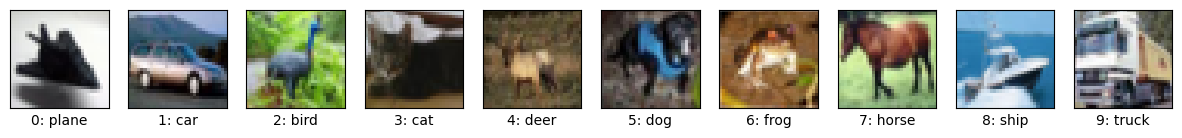

In [ ]:
#@title 3-1. 準備コード（ライブラリと関数の読み込み） { display-mode: "code" }
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

# PyTorch (AIの計算フレームワーク)
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# scikit-learn (t-SNE, 決定境界, データ分割, 標準化)
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 警告を非表示
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- PixelsInImage から追加 ---
import cv2
import urllib.request
from matplotlib.colors import LinearSegmentedColormap
# ------------------------------

# デバイス設定 (GPUが使えるか確認)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"使用するデバイス: {device}")

# CIFAR-10のクラス名
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# --- データの前処理と読み込み ---
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 学習用データセットをダウンロード
try:
    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform)
    # テストデータセットをダウンロード
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
except Exception as e:
    print(f"データセットのダウンロードに失敗しました: {e}")
    print("ネットワーク接続を確認するか、ランタイムを再起動してください。")

# 学習用データセットを「教師データ」と「検証データ」に分割
# 50000件のうち、40000件を教師データ、10000件を検証データに
train_indices, val_indices = train_test_split(
    list(range(len(trainset_full))),
    test_size=0.2, # 20%を検証用
    random_state=42
)
train_dataset = Subset(trainset_full, train_indices)
validation_dataset = Subset(trainset_full, val_indices)

print(f"全学習データ: {len(trainset_full)}件")
print(f"  教師データ: {len(train_dataset)}件")
print(f"  検証データ: {len(validation_dataset)}件")
print(f"テストデータ: {len(testset)}件")

# --- t-SNE と 決定境界のための関数 ---

# 特徴抽出関数
def extract_features(model, dataloader, device):
    model.eval() # 評価モード
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # fc2層の出力（84次元）を特徴として抽出
            features = model.extract_features(images)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    all_features = np.concatenate(features_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)
    return all_features, all_labels

# t-SNE実行関数
def run_tsne(features, random_state=42):
    # データを標準化
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # t-SNE
    # perplexityはデータの密度に依存。サンプル数が多いので40程度に設定
    tsne = TSNE(n_components=2, perplexity=40, random_state=random_state, n_iter=300, verbose=0)
    features_tsne = tsne.fit_transform(features_scaled)
    return features_tsne

# t-SNE可視化関数
def plot_tsne(features_tsne, labels, title):
    df_vis = pd.DataFrame({
        'tsne_x': features_tsne[:, 0],
        'tsne_y': features_tsne[:, 1],
        'label': labels
    })
    df_vis['class_name'] = df_vis['label'].apply(lambda x: classes[x])

    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("tab10", 10)
    sns.scatterplot(
        data=df_vis.sample(frac=1, random_state=42), # 描画順をシャッフル
        x='tsne_x', y='tsne_y',
        hue='class_name',
        palette=palette,
        s=10,
        alpha=0.7,
        legend='full'
    )
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

# 決定境界の可視化関数
def plot_decision_boundary(X_2d, y_2d, mlp_2d, title):
    print("決定境界をプロット中...")

    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    h = (x_max - x_min) / 100 # メッシュの解像度
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = mlp_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12, 10))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap("tab10", 10))

    # データポイントの散布図 (t-SNEと同じ)
    palette = sns.color_palette("tab10", 10)
    sns.scatterplot(
        x=X_2d[:, 0],
        y=X_2d[:, 1],
        hue=y_2d,
        palette=palette,
        s=5,
        alpha=0.5,
        legend='full'
    )

    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [classes[int(label)] for label in labels]
    plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# --- PixelsInImage から追加 ---
# ピクセル値を文字として表示し、格子を描画する汎用関数
def show_channel_with_grid_and_values(ax, data, title, cmap='gray', vmin=0, vmax=255):
    ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis("off")
    # 格子を描画
    for i in range(data.shape[0] + 1):
        ax.axhline(i - 0.5, color='white', lw=1)
    for j in range(data.shape[1] + 1):
        ax.axvline(j - 0.5, color='white', lw=1)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # テキストの色を濃度値に応じて変更
            val = data[i, j]
            text_color = "white"
            if cmap == 'gray' and val > 128:
                text_color = 'black'
            elif cmap == 'Red_cmap' and val > 200:
                 text_color = 'black'
            elif cmap == 'Green_cmap' and val > 180:
                text_color = 'black'
            elif cmap == 'Blue_cmap' and val > 180:
                text_color = 'black'

            ax.text(j, i, f"{val:3}", ha="center", va="center", color=text_color, fontsize=10)

# カスタムカラーマップを定義
cdict_red = {'red':   ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)), 'green': ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 'blue':  ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0))}
Red_cmap = LinearSegmentedColormap('Red_cmap', segmentdata=cdict_red, N=256)
cdict_green = {'red':   ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 'green': ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)), 'blue':  ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0))}
Green_cmap = LinearSegmentedColormap('Green_cmap', segmentdata=cdict_green, N=256)
cdict_blue = {'red':   ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 'green': ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 'blue':  ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))}
Blue_cmap = LinearSegmentedColormap('Blue_cmap', segmentdata=cdict_blue, N=256)
# ------------------------------

print("\n準備完了。")


print("\n--- CIFAR-10 クラスの例 ---")

# trainset_full から各クラスの最初の画像を収集
class_images = {}
for img, label in trainset_full:
    if label not in class_images:
        class_images[label] = img
    if len(class_images) == 10:
        break

# 画像の正規化を元に戻す関数 (plt.axis('off') を削除)
def imshow_example(img_tensor):
    img = img_tensor / 2 + 0.5  # 正規化解除
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.axis('off') # <- これを削除し、呼び出し側で制御

# 10クラスの画像を表示 (ソートして 0: plane, 1: car ... の順にする)
plt.figure(figsize=(15, 3))
sorted_labels = sorted(class_images.keys())
for i in sorted_labels:
    ax = plt.subplot(1, 10, i + 1)
    imshow_example(class_images[i])
    # タイトルの代わりに X軸ラベルをキャプションとして使用
    ax.set_xlabel(f"{i}: {classes[i]}")
    # 軸の目盛りを非表示にする
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## 🖼️ 3-2. 画像とピクセル値

AIが画像を「計算」するとはどういうことか、より具体的に理解するために、画像が「数値の集まり（ピクセル値）」であることを確認します。

以下のセルは、CIFAR-10の画像（32x32ピクセル）を読み込み、スライダーで指定した「関心領域（ROI）」のピクセル値を、R (赤), G (緑), B (青) の各色チャンネルごとに表示するものです。

* `image_index` で画像の番号を指定します。
* `manual_x`, `manual_y` でROIの左上の座標を決めます。
* `manual_width`, `manual_height` でROIのサイズを決めます。

CIFAR-10 画像 0 (cat) の ROI (X=10, Y=10, Size=8x8) を表示します。


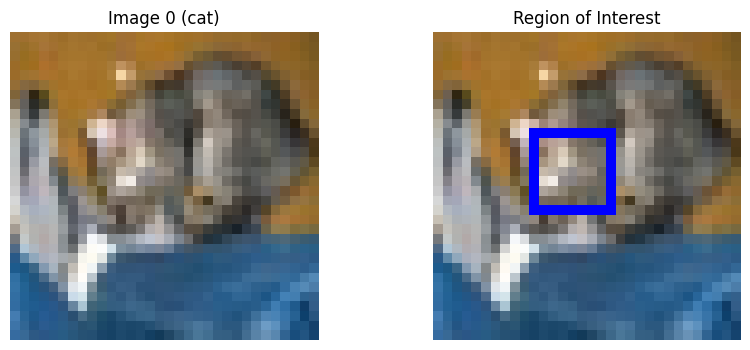

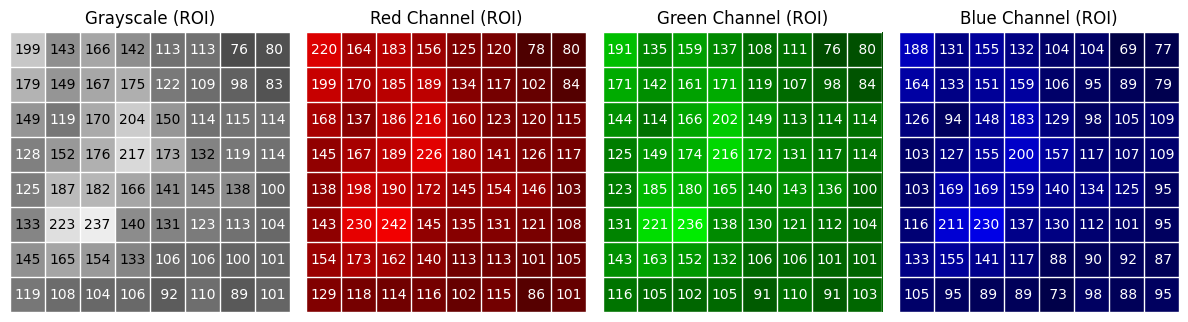

In [ ]:
#@title 3-2. ピクセル値の可視化（CIFAR-10画像） { display-mode: "code" }
#@markdown ### 画像インデックスとROIの指定
image_index = 0 #@param {type:"slider", min:0, max:9999, step:1}
roi_x = 10 #@param {type:"slider", min:0, max:31, step:1}
roi_y = 10 #@param {type:"slider", min:0, max:31, step:1}
roi_size = 8 #@param {type:"slider", min:1, max:16, step:1}

# --- CIFAR-10画像データの取得 ---
# testsetは transform (正規化) 済みなので、ピクセル値確認用に
# transformなしのデータセットを再ロード（ダウンロードはキャッシュされる）
transform_vis = transforms.Compose([transforms.ToTensor()])
testset_vis = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_vis)

# 0-9999 の範囲に補正
image_index = max(0, min(image_index, len(testset_vis)-1))

# (C, H, W) 形式のテンソルを取得
img_tensor, label = testset_vis[image_index]

# (H, W, C) 形式のNumpy配列に変換 (0-1の値)
img_np = img_tensor.permute(1, 2, 0).numpy()
# 0-255 の整数値に変換
img_rgb = (img_np * 255).astype(np.uint8)

# グレースケール変換
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# --- ROIの決定 ---
final_x, final_y, final_w, final_h = roi_x, roi_y, roi_size, roi_size
print(f"CIFAR-10 画像 {image_index} ({classes[label]}) の ROI (X={final_x}, Y={final_y}, Size={roi_size}x{roi_size}) を表示します。")

# 座標が画像の範囲外にならないように補正
final_x = max(0, min(final_x, img_rgb.shape[1] - final_w))
final_y = max(0, min(final_y, img_rgb.shape[0] - final_h))
# サイズが画像サイズを超えないように補正
final_w = min(final_w, img_rgb.shape[1] - final_x)
final_h = min(final_h, img_rgb.shape[0] - final_y)


# 見つかった領域を矩形で囲む
image_with_rect = img_rgb.copy()
cv2.rectangle(image_with_rect, (final_x, final_y), (final_x + final_w, final_y + final_h), (0, 0, 255), 1)

# 拡大する部分の座標
roi_gray = gray[final_y:final_y+final_h, final_x:final_x+final_w]
roi_r = img_rgb[final_y:final_y+final_h, final_x:final_x+final_w, 0]
roi_g = img_rgb[final_y:final_y+final_h, final_x:final_x+final_w, 1]
roi_b = img_rgb[final_y:final_y+final_h, final_x:final_x+final_w, 2]

# --- グラフ描画 ---
# 1. 全体像のプロット
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_rgb)
ax1.set_title(f"Image {image_index} ({classes[label]})")
ax1.axis("off")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(image_with_rect)
ax2.set_title("Region of Interest")
ax2.axis("off")
plt.show()

# 2. ROIの詳細プロット
fig, axes = plt.subplots(1, 4, figsize=(max(9, final_w*1.5), max(4, final_h*0.6)))
show_channel_with_grid_and_values(axes[3], roi_b, "Blue Channel (ROI)", cmap=Blue_cmap)
show_channel_with_grid_and_values(axes[2], roi_g, "Green Channel (ROI)", cmap=Green_cmap)
show_channel_with_grid_and_values(axes[1], roi_r, "Red Channel (ROI)", cmap=Red_cmap)
show_channel_with_grid_and_values(axes[0], roi_gray, "Grayscale (ROI)")
plt.tight_layout()
plt.show()

## 🧠 4. AIの脳（CNNモデル）を設計する

CNN（畳み込みニューラルネットワーク）の計算ルール（構造）を設計します。

### 🌀 「畳み込み(Convolution)」とは？

「畳み込み」とは、画像から「特徴」を抜き出すための計算です。
虫眼鏡（**カーネル**または**フィルタ**と呼ばれる）で画像の一部を拡大し、その部分が「縦線」っぽいか、「丸」っぽいか、「赤」っぽいかなどを調べ、その結果（**特徴マップ**）を新しい画像として出力します。



この虫眼鏡（カーネル）自体が、AIが学習によって自動で調整する「計算ルールの重み」です。学習が進むと、AIは「ネコを分類するには、この部分に注目する虫眼鏡が必要だ」ということを自動で見つけ出します。

### 📜 モデルの構造

今回は、以下のような流れで計算するモデルを設計します。
（`->` は計算の流れを示します）

1.  **入力** (32x32ピクセルのカラー画像)
2.  **畳み込み 1 (conv1)**: 虫眼鏡で特徴を抜き出す
3.  **プーリング 1 (pool)**: 画像を粗く（小さく）して、大まかな特徴だけ残す
4.  **畳み込み 2 (conv2)**: もう一度、別の虫眼鏡で特徴を抜き出す
5.  **プーリング 2 (pool)**: 再び画像を粗くする
6.  **平坦化 (view)**: 2次元の画像データを、1列の数値データに変換する
7.  **全結合 1 (fc1)**: 1列のデータを元に、より複雑な計算
8.  **全結合 2 (fc2)**: さらにもう一段計算（ここで84個の数値＝**特徴ベクトル**が完成）
9.  **全結合 3 (fc3)**: 84個の数値を、最終的な10クラスの「確率」に変換
10. **出力** (10個の数値)

In [ ]:
#@title CNNモデルの定義と構造の表示 { display-mode: "code" }

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1. 畳み込み層 (入力3ch, 出力6ch, カーネル5x5)
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 2. プーリング層 (2x2)
        self.pool = nn.MaxPool2d(2, 2)
        # 3. 畳み込み層 (入力6ch, 出力16ch, カーネル5x5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # 4. 全結合層 (入力 16*5*5 = 400, 出力 120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 5. 全結合層 (入力 120, 出力 84)
        self.fc2 = nn.Linear(120, 84)
        # 6. 全結合層 (入力 84, 出力 10クラス)
        self.fc3 = nn.Linear(84, 10)

    # 計算の流れ (forward)
    def forward(self, x):
        # 畳み込み1 -> ReLU活性化 -> プーリング
        x = self.pool(F.relu(self.conv1(x)))
        # 畳み込み2 -> ReLU活性化 -> プーリング
        x = self.pool(F.relu(self.conv2(x)))

        # 平坦化 (1列の数値にする)
        x = x.view(-1, 16 * 5 * 5)

        # 全結合1 -> ReLU活性化
        x = F.relu(self.fc1(x))
        # 全結合2 -> ReLU活性化
        x = F.relu(self.fc2(x))
        # 全結合3 (最終出力層)
        x = self.fc3(x)
        return x

    # 特徴抽出用のメソッド (fc2の出力を取り出す)
    def extract_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        features = F.relu(self.fc2(x)) # fc3の手前(84次元)
        return features

# モデルの実体を作成し、GPU(device)に送る
net_before_learning = Net().to(device)

# モデルの構造をテキストで出力
print("--- AI(CNN)の構造 ---")
print(net_before_learning)
print("--------------------")

--- AI(CNN)の構造 ---
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
--------------------


## 📊 5. 学習前のAIの実力（t-SNE可視化）

今、AI（`net_before_learning`）は「生まれたて」の状態で、中身の計算ルール（重み）はランダム（でたらめ）です。
この状態で画像を見せても、まともな特徴は取り出せません。

「検証データ」を使って、この「生まれたてのAI」が画像をどう見ているか、t-SNEで可視化してみましょう。
（t-SNEの計算には少し時間がかかります）

学習前のモデルで特徴を抽出中...
t-SNEで2次元に圧縮中...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


可視化中...


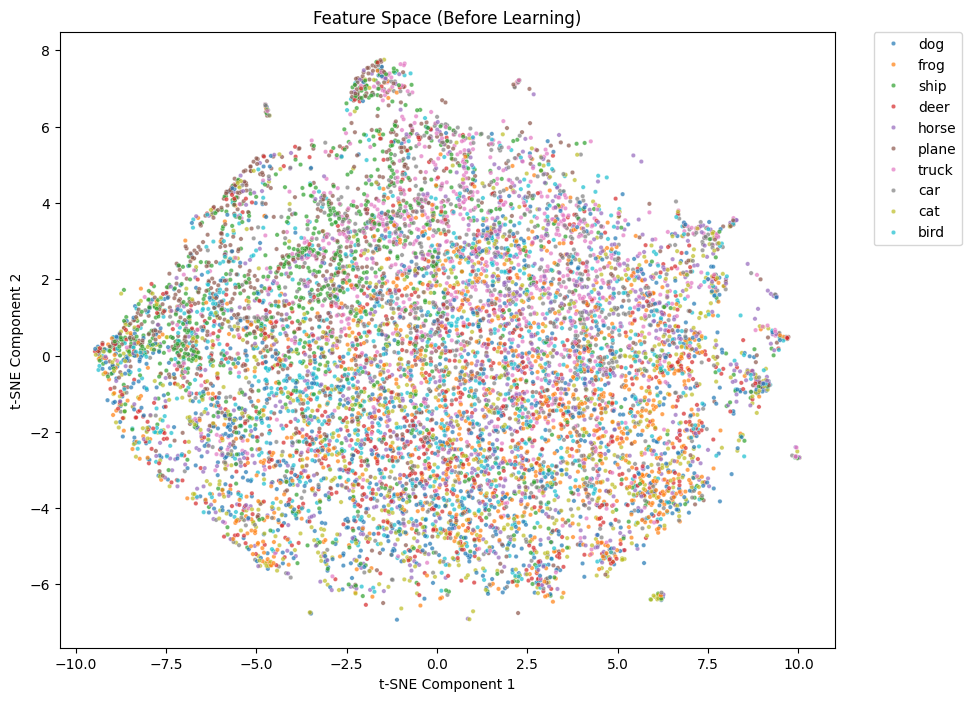

In [ ]:
#@title 学習前のt-SNE可視化 (実行に1〜2分かかります) { display-mode: "code" }

# 検証データセット用のDataLoader
validation_loader_vis = DataLoader(validation_dataset, batch_size=100, shuffle=False)

# 学習前の特徴抽出
print("学習前のモデルで特徴を抽出中...")
features_before, labels_before = extract_features(net_before_learning, validation_loader_vis, device)

# t-SNE実行
print("t-SNEで2次元に圧縮中...")
tsne_before = run_tsne(features_before)

# 可視化
print("可視化中...")
plot_tsne(tsne_before, labels_before, "Feature Space (Before Learning)")

## ⚙️ 6. AIの学習：計算ルールを調整する

AIの学習プロセスを設定します。

### 🎛️ ハイパーパラメータの設定（フォーム）

学習の「やり方」を決める重要な設定値（**ハイパーパラメータ**）を決めます。
（Pythonが分からない方も、ここで数値を変更して学習の様子を変えられます）

* **max_epochs:** 教師データを何回繰り返し学習するか（最大回数）。
* **learning_rate (学習率):** 誤差をどれだけ強く計算ルールに反映するか。大きすぎると学習が不安定になり、小さすぎると時間がかかりすぎます。
* **batch_size (バッチサイズ):** 一度に何枚の画像をまとめて処理するか。

In [ ]:
#@title 6-1. ハイパーパラメータ設定
max_epochs = 10 #@param {type:"integer"}
learning_rate = 0.001 #@param {type:"number"}
batch_size = 64 #@param {type:"integer"}

# --- データローダーの作成 ---
# 教師データ (学習中はバラバラに混ぜる shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# 検証データ (混ぜる必要なし shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# テストデータ (混ぜる必要なし shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# --- モデル、損失関数、最適化手法の定義 ---
# 新しく「学習させるため」のモデルを用意
net_to_train = Net().to(device)

# 損失関数 (誤差を計算するルール)
# 「クロスエントロピー誤差」という、分類問題で一般的な計算尺を使います
criterion = nn.CrossEntropyLoss()

# 最適化手法 (誤差をどう反映させるか)
# 「Adam」という、効率よく計算ルールを調整してくれる手法を使います
optimizer = optim.Adam(net_to_train.parameters(), lr=learning_rate)

print("学習の準備完了。")

学習の準備完了。


### 🚀 6-2. 学習の実行：誤差逆伝播法

いよいよ学習を実行します。AIは以下のサイクルを高速で繰り返します。

1.  **入力:** 教師データをいくつか取り出す（バッチ処理）。
2.  **順伝播 (計算):** モデル（AI）が画像を計算し、確率（予測）を出す。
3.  **誤差の計算:** AIの予測と「正解」を比べる。
    * **理想:** 正解クラス（例：ネコ）の確率が $1.0$、他が $0.0$。
    * **予測:**「ネコ $0.6$、イヌ $0.3$、車 $0.1$」...
    * この**「ズレ」が「誤差（損失）」**です。
4.  **誤差逆伝播法 (Backpropagation):**
    計算された「誤差」を、計算ルールの調整に使うため、**AI（モデル）の中を逆向きに伝播**させます。「この誤差は、さっきの計算（fc3）のせいだ」「じゃあ、その前のfc2のせいだ」...と遡っていきます。
5.  **更新:**
    逆伝播でわかった「誤差の原因」に基づき、計算ルール（重み）を**「誤差が少し小さくなる」方向にほんの少しだけ**調整します（学習率 `learning_rate` がこの「少し」の量を決めます）。

このサイクルを、教師データ全体で「1エポック (epoch)」と呼びます。今回はこれを `max_epochs` 回繰り返します。

学習を開始します... (最大10エポック)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] | Train Loss: 1.693, Train Acc: 37.77% | Val Loss: 1.482, Val Acc: 45.75%
Epoch [2/10] | Train Loss: 1.417, Train Acc: 48.83% | Val Loss: 1.343, Val Acc: 51.99%
Epoch [3/10] | Train Loss: 1.301, Train Acc: 53.41% | Val Loss: 1.284, Val Acc: 54.46%
Epoch [4/10] | Train Loss: 1.215, Train Acc: 56.58% | Val Loss: 1.221, Val Acc: 55.95%
Epoch [5/10] | Train Loss: 1.144, Train Acc: 59.37% | Val Loss: 1.163, Val Acc: 58.47%
Epoch [6/10] | Train Loss: 1.093, Train Acc: 61.11% | Val Loss: 1.148, Val Acc: 59.15%
Epoch [7/10] | Train Loss: 1.050, Train Acc: 62.72% | Val Loss: 1.149, Val Acc: 59.37%
Epoch [8/10] | Train Loss: 1.015, Train Acc: 63.99% | Val Loss: 1.102, Val Acc: 61.83%
Epoch [9/10] | Train Loss: 0.975, Train Acc: 65.43% | Val Loss: 1.102, Val Acc: 61.39%
Epoch [10/10] | Train Loss: 0.944, Train Acc: 66.71% | Val Loss: 1.105, Val Acc: 61.71%

学習が終了しました。


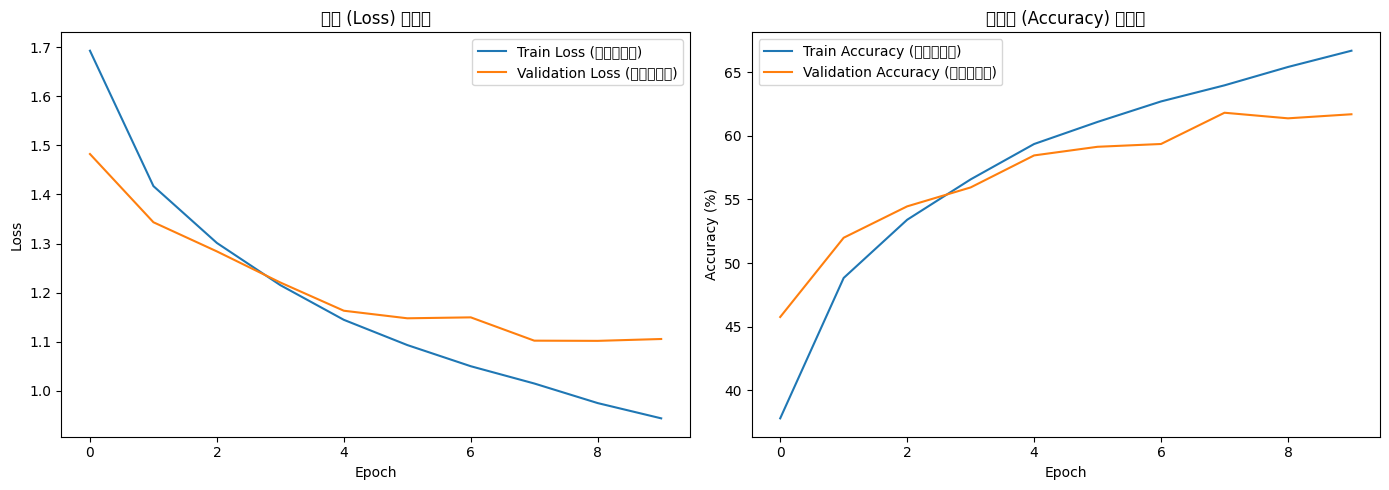

In [ ]:
#@title 6-2. 学習の実行 (max_epochsに応じて数分〜数十分かかります) { display-mode: "code" }

# 各エポックの損失と精度を記録するリスト
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

print(f"学習を開始します... (最大{max_epochs}エポック)")

# tqdmを使って進捗バーを表示
for epoch in tqdm(range(max_epochs), desc="Epochs"):

    # --- 1. 教師データでの学習 (Train) ---
    net_to_train.train() # 学習モード
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # train_loader からバッチごとにデータを取り出す
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # (1) 勾配をリセット (前の計算結果を消す)
        optimizer.zero_grad()

        # (2) 順伝播 (計算)
        outputs = net_to_train(inputs)

        # (3) 誤差の計算
        loss = criterion(outputs, labels)

        # (4) 誤差逆伝播
        loss.backward()

        # (5) 更新
        optimizer.step()

        # --- 学習状況の記録 ---
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- 2. 検証データでの評価 (Validation) ---
    net_to_train.eval() # 評価モード
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # 勾配計算をオフ
        # validation_loader からバッチごとにデータを取り出す
        for data in validation_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net_to_train(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(validation_loader)
    val_acc = 100 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # エポックごとの結果を表示 (tqdmの進捗バーに表示)
    tqdm.write(f"Epoch [{epoch+1}/{max_epochs}] | "
             f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}% | "
             f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}%")

print("\n学習が終了しました。")

# --- 学習曲線のプロット ---
plt.figure(figsize=(14, 5))

# 損失 (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 精度 (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### 🧠 可視化結果の考察（学習曲線）

* **誤差 (Loss)**:
    学習が進むにつれて、教師データ（青線）と検証データ（オレンジ線）の両方で、誤差（ズレ）が小さくなっていくのが分かります。AIが正解に近づいている証拠です。
* **正解率 (Accuracy)**:
    逆に、正解率はどんどん上がっていきます。

もし、教師データの線だけが良くなり、検証データの線が悪化し始めたら、それは「教師データを丸暗記しすぎた（**過学習**）」状態です。検証データは、それを見抜くために使われます。

## 📊 7. 学習後のAIの実力

さて、学習によって「賢く」なったAI（`net_to_train`）は、画像の「特徴」をうまく捉えられるようになったでしょうか？
学習前と同じように、検証データを使ってt-SNEで可視化してみましょう。

学習後のモデルで特徴を抽出中...
t-SNEで2次元に圧縮中...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


可視化中...


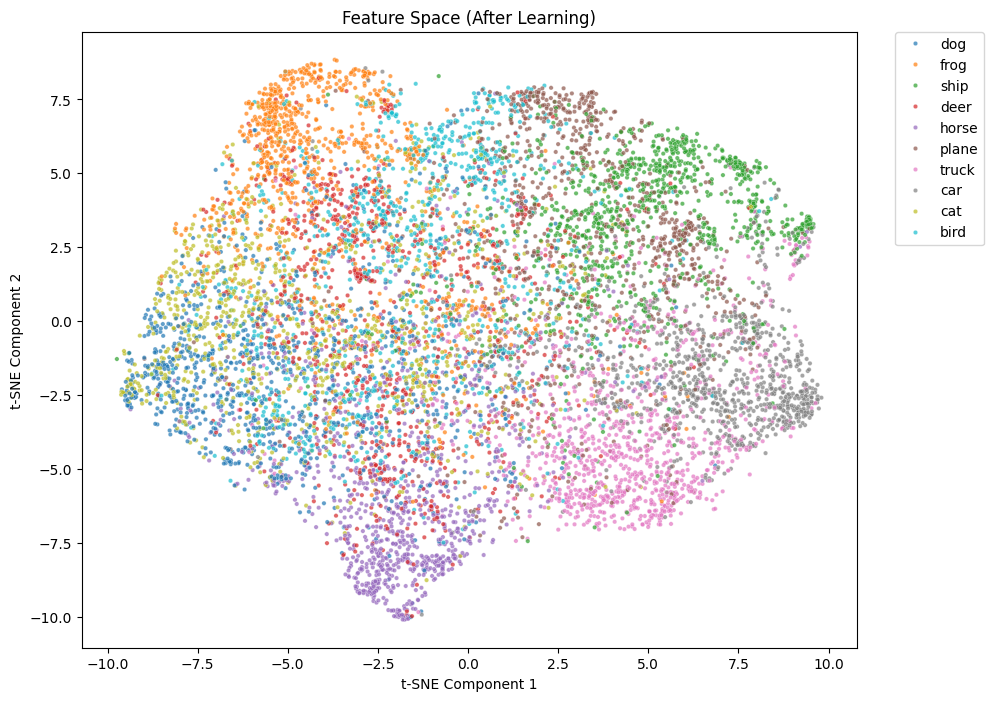

In [ ]:
#@title 学習後のt-SNE可視化 (実行に1〜2分かかります) { display-mode: "code" }

# 学習後の特徴抽出 (検証データローダーは6-1で定義した validation_loader を再利用)
print("学習後のモデルで特徴を抽出中...")
features_after, labels_after = extract_features(net_to_train, validation_loader, device)

# t-SNE実行
print("t-SNEで2次元に圧縮中...")
tsne_after = run_tsne(features_after)

# 可視化
print("可視化中...")
plot_tsne(tsne_after, labels_after, "Feature Space (After Learning)")

### 🧠 可視化結果の考察（学習後）

学習前のぐちゃぐちゃだったグラフと比べてみてください。
**同じ色の点（同じクラス）が近くに集まり、異なる色の点が離れて、「クラスタ（塊）」が形成されている**のが分かります。

これは、AIが学習によって、3072次元（32x32x3）の画像データを、**「クラスごとに分類しやすい」84次元の特徴空間**に変換する計算ルール（畳み込みカーネルや重み）を、自動で獲得したことを意味します。

## 🗺️ 8. 最終テストと「決定境界」の可視化

AIの学習は「分類しやすい特徴空間」を作ることでした。
この空間（t-SNEで2次元にした空間）を使えば、クラスを分類する「仕切り線（**決定境界**）」を引くことができます。

学習後のt-SNE空間（`tsne_after`）を「新しいデータ」とみなして、この2次元空間上でクラスの仕切り線を学習させ、可視化してみましょう。

2次元空間で決定境界を学習中...
2D 分類器の訓練データ精度: 0.5170
決定境界をプロット中...


/tmp/ipython-input-2768038381.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap("tab10", 10))


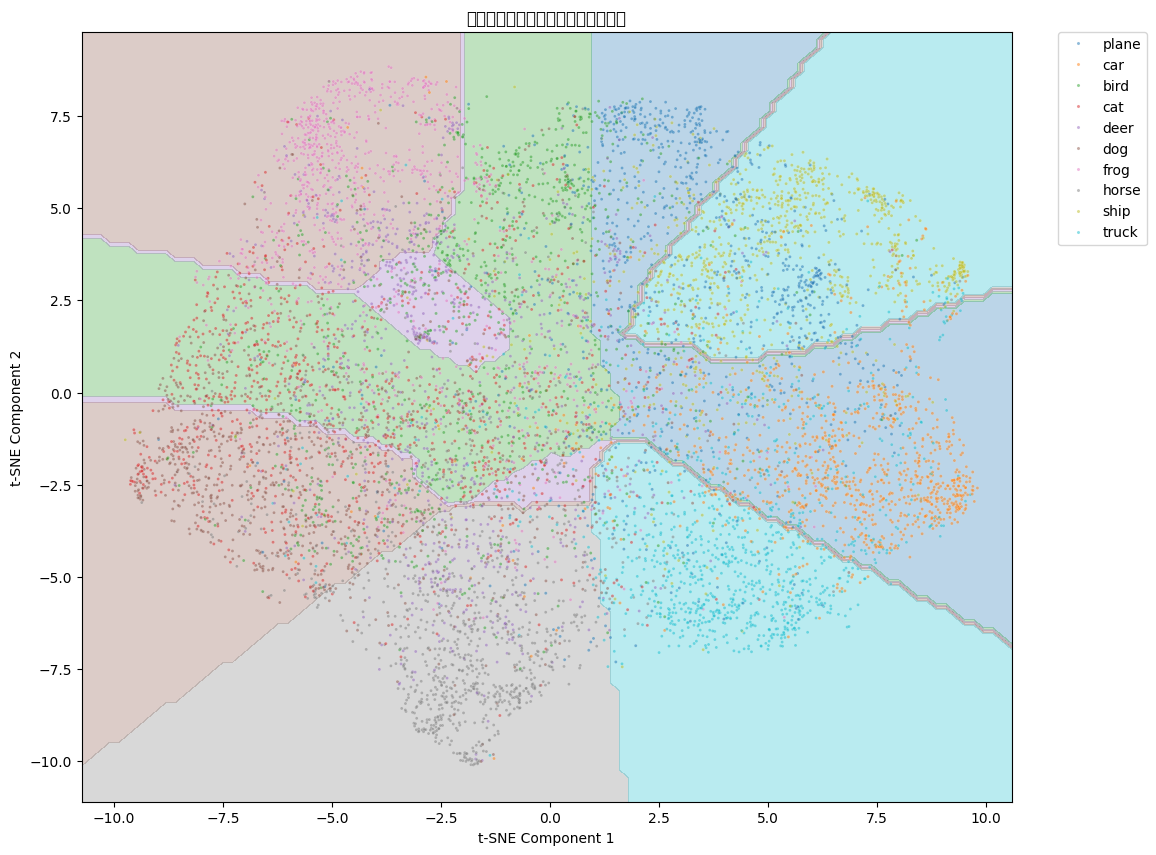

In [ ]:
#@title 8-1. 決定境界の学習と可視化 (実行に1〜2分かかります) { display-mode: "code" }

# t-SNEの2次元データ (X) とラベル (y)
X_2d = tsne_after
y_2d = labels_after

# 決定境界を学習するための、別の単純なAI (MLPClassifier) を用意
# (元のCNNとは別物です。2次元データを分類するためだけに使います)
print("2次元空間で決定境界を学習中...")
mlp_2d = MLPClassifier(
    hidden_layer_sizes=[50, 50],
    max_iter=500,
    random_state=42,
    alpha=0.01,
    batch_size=200,
    early_stopping=True,
    verbose=False
)
mlp_2d.fit(X_2d, y_2d)
print(f"2D 分類器の訓練データ精度: {mlp_2d.score(X_2d, y_2d):.4f}")

# 決定境界のプロット
plot_decision_boundary(X_2d, y_2d, mlp_2d, "Decision Boundaries (After Learning)")

### 🧠 可視化結果の考察（決定境界）

背景の色が「仕切り線（決定境界）」です。
AIが作った特徴空間（点）が、クラスごとにきれいに分かれているため、この2次元空間でもうまく仕切り線が引けていることがわかります。

（t-SNEの特性上、クラスタ間の「距離」は必ずしも正確な意味を持ちませんが、「近さ」は意味を持ちます。そのため、いくつかのクラスが混ざって見える領域もありますが、全体としてはうまく分離できています。）

### 💯 最終実力テスト（クラスごと）

最後に、学習に一切使っていない「テストデータ」を使って、学習済みAI（`net_to_train`）の最終的な実力を評価します。
全体の正解率だけでなく、どのクラスが得意で、どのクラスが苦手か、クラスごとの正解率も見てみましょう。

In [ ]:
#@title 8-2. 最終テスト（テストデータでの精度評価） { display-mode: "code" }

net_to_train.eval() # 評価モード
correct_test = 0
total_test = 0

# クラスごとの正解数をカウントする準備
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    # test_loader は 6-1 で定義済み
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # 計算
        outputs = net_to_train(images)

        # 確率が最大のクラスを予測結果とする
        _, predicted = torch.max(outputs.data, 1)

        # 全体の正解率を計算
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # クラスごとの正解率を計算
        c = (predicted == labels).squeeze()
        for i in range(len(labels)): # バッチサイズ（通常64）でループ
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# --- 全体の正解率を表示 ---
final_accuracy = 100 * correct_test / total_test
print(f"--- 最終実力テスト結果 ---")
print(f"テストデータ {total_test} 件に対する全体の正解率: {final_accuracy:.2f} %")
print("--------------------")

# --- クラスごとの正解率を表示 ---
print("クラスごとの正解率:")
for i in range(10):
    if class_total[i] > 0:
        print(f'  {classes[i]:<10} : {100 * class_correct[i] / class_total[i]:.2f} %')
    else:
        print(f'  {classes[i]:<10} : データなし')

--- 最終実力テスト結果 ---
テストデータ 10000 件に対する全体の正解率: 62.00 %
--------------------
クラスごとの正解率:
  plane      : 68.00 %
  car        : 83.40 %
  bird       : 61.00 %
  cat        : 30.70 %
  deer       : 47.70 %
  dog        : 50.90 %
  frog       : 78.20 %
  horse      : 60.80 %
  ship       : 70.30 %
  truck      : 69.00 %


### 🖼️ 8-3. 個別の推定結果の確認

テスト画像のうち、いくつかのサンプルを実際に表示して、AIの「正解」と「推定」がどうなっているか確認してみましょう。
（実行するたびに、別の画像が表示されます）

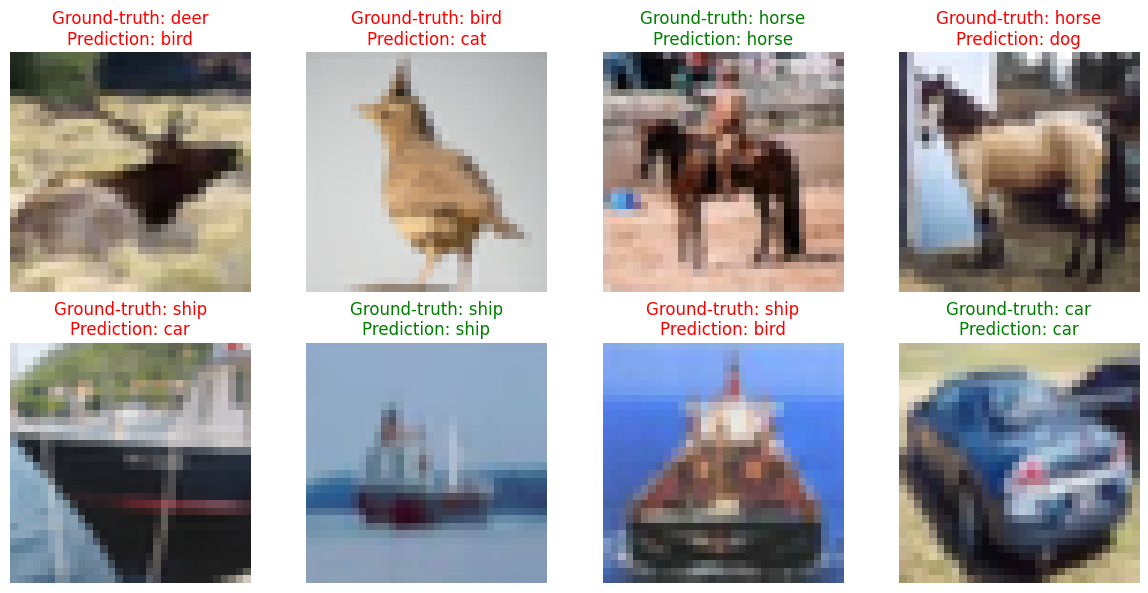

In [ ]:
#@title 8-3. 個別の推定結果を表示 { display-mode: "code" }

# test_loader をシャッフルして再作成（毎回違う画像を見るため）
vis_loader = DataLoader(testset, batch_size=8, shuffle=True)

# 1バッチ分のデータを取得
images, labels = next(iter(vis_loader))
images_gpu, labels_gpu = images.to(device), labels.to(device)

# 推定
net_to_train.eval()
with torch.no_grad():
    outputs = net_to_train(images_gpu)
    _, predicted = torch.max(outputs, 1)

# CPUに戻す
predicted = predicted.cpu()

# 画像の正規化を元に戻す（表示のため）
def imshow(img):
    img = img / 2 + 0.5     # 正規化解除 ( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 結果の表示
plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images[i])

    # 正解と推定のラベル
    true_label = classes[labels[i]]
    pred_label = classes[predicted[i]]

    # 色分け
    color = "green" if true_label == pred_label else "red"

    ax.set_title(f"Ground-truth: {true_label}\nPrediction: {pred_label}", color=color)

plt.tight_layout()
plt.show()

## 🏁 9. まとめ

このノートブックでは、AI（CNN）の学習と分類のプロセスを可視化しました。

1.  **AIは「計算」:**
    AIは高次元の「数値（画像）」を、計算ルール（モデル）に従って処理し、低次元の「数値（確率や特徴）」に変換する計算機です。
2.  **学習とは「計算ルールの調整」:**
    学習前のAI（ランダムなルール）では、特徴空間はぐちゃぐちゃでした。
3.  **教師あり学習と誤差:**
    「正解」と「予測」の「ズレ（誤差）」を計算し、その誤差が小さくなるように計算ルールを少しずつ調整（**誤差逆伝播法**）しました。
4.  **CNNと特徴空間:**
    学習後のAIは、画像から「分類に役立つ特徴（特徴ベクトル）」を自動で抽出し、クラスごとに集まった「クラスタ」を形成できるようになりました。
5.  **分類とは「確率の最大化」:**
    AIは、入力された画像が、学習によって作られた特徴空間の「どのクラスタ（クラス）に最も近いか」を「確率」として計算し、最も高い確率のクラスを「答え」として出力します。

AIの「学習」とは、このように、入力データを「**答えやすい（分類しやすい）形に変換する計算ルール**」を、大量のデータと誤差のフィードバックによって自動で見つけ出すプロセスである、と視覚的に理解できます。